# A5 1-D and 2-D Convolutional Neural Networks in Pytorch

* A5.4: *Changed structure of `CNN2D.__init__` by having it call `make_cnn_and_fc_layers` function. It is this function that `CNN1D` must override., not the `__init__` constructor.*
* A5.3: *Added two missing statements in `CNN2D` that initialize `layeri` to 0 and increment it by 1*
* A5.2: *added an exception to `CNN2D.__init__` code that provides a helpful message if you specify an impossible configuration for convolutional layers.  Repeat this exception code in your `CNN1D.__init__` function.*
* A5.1: *small edit in CNN2D to allow empty list for `n_hiddens_per_fc_layer`.*

In this assignment, you will experiment with the given convolutional neural network for 2-dimensional input samples (images), in class `CNN2D`, by applying it to the MNIST data.  You will also define a new class for handling 1-dimensional input samples, called `CNN1D`, that extends `CNN2D`.

In [1]:
import numpy as np
import torch
import pandas

import matplotlib.pyplot as plt

## `CNN2D` class

Here is a definition of `CNN2D`.

In [2]:
import numpy as np
import torch


class CNN2D(torch.nn.Module):

    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):

        super().__init__()

        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers
            or len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')

        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu

        self.make_conv_and_fc_layers(n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                     patch_size_per_conv_layer, stride_per_conv_layer)
        
        self.Xmeans = None
        self.to(self.device)

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
                # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            if conv_layer_output_hw <= 0:
                raise Exception(f'''For conv layer {layeri}, input_hw of {input_hw} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh
            layeri += 1
           
        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append(self.activation_function(conv_layer(Ys[-1])))

        flattened_input = Ys[-1].reshape(n_samples, -1)

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append(self.activation_function(fc_layer(flattened_input)))
            else:
                Ys.append(self.activation_function(fc_layer(Ys[-1])))

        if len(self.fc_layers) == 1:
            # only the output layer
            Ys.append(self.fc_layers[-1](flattened_input))
        else:
            Ys.append(self.fc_layers[-1](Ys[-1]))

        return Ys

    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        '''X and T must be numpy arrays'''

        self.classes = np.unique(T)
        T = np.arange(len(self.classes))[np.where(T.reshape(-1, 1) == self.classes)[1]]

        # Set data matrices to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds

        X.requires_grad_(True)

        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []

        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0

            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]

                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (max(1, n_epochs // 10)) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self

    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1, 1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y

    def use(self, X):
        # Set input matrix to torch.tensors
        X = torch.from_numpy(X).float().to(self.device)
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        # Calculate output of net for all samples in X
        Y = self.forward(X)
        # Convert output to class probabilities
        probs = self.softmax(Y)
        # For each sample pick highest probability and translate that to class labels
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()].reshape(-1, 1)
        return classes, probs.detach().cpu().numpy()

### CNN2D on MNIST Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz` if you don't already have it from A4. 

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [3]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 784) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [4]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cpu


In [5]:
len(np.unique(Ttrain))

10

adam: Epoch 2 Loss 0.429
adam: Epoch 4 Loss 0.266
adam: Epoch 6 Loss 0.227
adam: Epoch 8 Loss 0.196
adam: Epoch 10 Loss 0.184
adam: Epoch 12 Loss 0.176
adam: Epoch 14 Loss 0.164
adam: Epoch 16 Loss 0.163
adam: Epoch 18 Loss 0.159
adam: Epoch 20 Loss 0.155


Text(0.5, 1.0, 'MNIST')

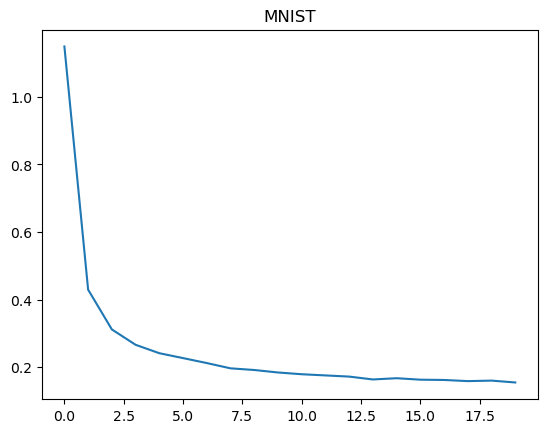

In [6]:
n_hiddens_per_conv_layer = [10, 10]
patch_size_per_conv_layer = [10, 5]
stride_per_conv_layer=[4, 2]
n_hiddens_per_fc_layer = [5]

cnnet = CNN2D(28 * 28, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, len(np.unique(Ttrain)), 
              patch_size_per_conv_layer, stride_per_conv_layer, device=device)

n_epochs = 20
batch_size = 500
learning_rate = 0.01

cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
cnnet.error_trace = [e.detach().numpy() for e in cnnet.error_trace]

plt.plot(cnnet.error_trace, label='Pytorch')
plt.title('MNIST')

In [7]:
def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [8]:
Classes, _ = cnnet.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 94.12


,0,1,2,3,4,5,6,7,8,9
0,97.551020,0.000000,0.612245,0.102041,0.000000,0.204082,0.714286,0.204082,0.306122,0.306122
1,0.000000,98.414097,0.440529,0.176211,0.176211,0.000000,0.176211,0.176211,0.440529,0.000000
2,0.193798,0.678295,94.186047,2.325581,0.290698,0.000000,0.193798,0.968992,1.162791,0.000000
3,0.099010,0.396040,1.683168,94.455446,0.198020,0.792079,0.000000,1.782178,0.396040,0.198020
4,0.000000,0.203666,0.203666,0.000000,95.926680,0.101833,0.916497,0.916497,0.203666,1.527495
5,1.121076,0.000000,0.560538,6.614350,0.784753,87.219731,1.233184,0.000000,1.793722,0.672646
6,1.043841,0.313152,0.939457,0.104384,0.626305,0.730689,95.511482,0.104384,0.417537,0.208768
7,0.097276,0.778210,1.361868,1.070039,0.583658,0.000000,0.000000,94.649805,0.097276,1.361868
8,1.129363,0.513347,0.718686,2.566735,0.205339,1.745380,0.616016,0.821355,91.170431,0.513347
9,0.396432,0.594648,0.000000,0.495540,4.261645,0.396432,0.000000,2.477701,0.495540,90.882061


### Experiments

To explore the effects of different CNN structures, show results for the following steps.  For each architecture, use the same number of epochs, batch size, and learning rate as used above.

1. Compare test accuracy of CNN2D nets with one, two and three convolutional layers, each with 10 units and patch sizes of 5 and strides of 1.
2. Using the best number of convolutional layers found in Step 1, compare the test accuracies of CNN2d nets with zero, one, and two fully-connected layers each with 10 hidden units.

Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [9]:
conv_architectures = [
    {'n_conv_layers': 1, 'n_hiddens_per_conv_layer': [10], 'patch_size_per_conv_layer': [5], 'stride_per_conv_layer': [1]},
    {'n_conv_layers': 2, 'n_hiddens_per_conv_layer': [10, 10], 'patch_size_per_conv_layer': [5, 5], 'stride_per_conv_layer': [1, 1]},
    {'n_conv_layers': 3, 'n_hiddens_per_conv_layer': [10, 10, 10], 'patch_size_per_conv_layer': [5, 5, 5], 'stride_per_conv_layer': [1, 1, 1]}
]

results_conv_layers = []
for arch in conv_architectures:
    cnnet = CNN2D(28 * 28, arch['n_hiddens_per_conv_layer'], [], len(np.unique(Ttrain)), 
                  arch['patch_size_per_conv_layer'], arch['stride_per_conv_layer'], device=device)
    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
    
    train_acc = np.mean(cnnet.use(Xtrain)[0] == Ttrain) * 100
    test_acc = np.mean(cnnet.use(Xtest)[0] == Ttest) * 100
    
    results_conv_layers.append({'Conv Layers': arch['n_conv_layers'], 
                                'Test Accuracy': test_acc, 
                                'Train Accuracy': train_acc})

results_conv_layers_df = pandas.DataFrame(results_conv_layers)

best_conv_result = results_conv_layers_df.iloc[results_conv_layers_df['Test Accuracy'].idxmax()]

print("Best result for convolutional layers:")
print(best_conv_result)
print()

adam: Epoch 2 Loss 0.302
adam: Epoch 4 Loss 0.198
adam: Epoch 6 Loss 0.170
adam: Epoch 8 Loss 0.148
adam: Epoch 10 Loss 0.137
adam: Epoch 12 Loss 0.139
adam: Epoch 14 Loss 0.141
adam: Epoch 16 Loss 0.130
adam: Epoch 18 Loss 0.138
adam: Epoch 20 Loss 0.129
adam: Epoch 2 Loss 0.232
adam: Epoch 4 Loss 0.130
adam: Epoch 6 Loss 0.169
adam: Epoch 8 Loss 0.136
adam: Epoch 10 Loss 0.180
adam: Epoch 12 Loss 0.166
adam: Epoch 14 Loss 0.166
adam: Epoch 16 Loss 0.113
adam: Epoch 18 Loss 0.081
adam: Epoch 20 Loss 0.095
adam: Epoch 2 Loss 0.200
adam: Epoch 4 Loss 0.123
adam: Epoch 6 Loss 0.146
adam: Epoch 8 Loss 0.143
adam: Epoch 10 Loss 0.120
adam: Epoch 12 Loss 0.144
adam: Epoch 14 Loss 0.102
adam: Epoch 16 Loss 0.109
adam: Epoch 18 Loss 0.091
adam: Epoch 20 Loss 0.088
Best result for convolutional layers:
Conv Layers        3.000
Test Accuracy     97.450
Train Accuracy    98.656
Name: 2, dtype: float64



In [10]:
best_conv_layers = int(best_conv_result['Conv Layers'])

fc_architectures = [
    {'n_fc_layers': 0, 'n_hiddens_per_fc_layer': []},
    {'n_fc_layers': 1, 'n_hiddens_per_fc_layer': [10]},
    {'n_fc_layers': 2, 'n_hiddens_per_fc_layer': [10, 10]}
]

results_fc_layers = []
for arch in fc_architectures:
    cnnet = CNN2D(28 * 28, [10] * best_conv_layers, arch['n_hiddens_per_fc_layer'], len(np.unique(Ttrain)), 
                  [5] * best_conv_layers, [1] * best_conv_layers, device=device)
    cnnet.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
    
    train_acc = np.mean(cnnet.use(Xtrain)[0] == Ttrain) * 100
    test_acc = np.mean(cnnet.use(Xtest)[0] == Ttest) * 100
    
    results_fc_layers.append({'FC Layers': arch['n_fc_layers'], 
                              'Test Accuracy': test_acc, 
                              'Train Accuracy': train_acc})

results_fc_layers_df = pandas.DataFrame(results_fc_layers)

best_fc_result = results_fc_layers_df.iloc[results_fc_layers_df['Test Accuracy'].idxmax()]

print("Best result for fully-connected layers:")
print(best_fc_result)
print()

adam: Epoch 2 Loss 0.192
adam: Epoch 4 Loss 0.133
adam: Epoch 6 Loss 0.167
adam: Epoch 8 Loss 0.109
adam: Epoch 10 Loss 0.113
adam: Epoch 12 Loss 0.092
adam: Epoch 14 Loss 0.091
adam: Epoch 16 Loss 0.082
adam: Epoch 18 Loss 0.102
adam: Epoch 20 Loss 0.080
adam: Epoch 2 Loss 0.310
adam: Epoch 4 Loss 0.241
adam: Epoch 6 Loss 0.224
adam: Epoch 8 Loss 0.195
adam: Epoch 10 Loss 0.176
adam: Epoch 12 Loss 0.187
adam: Epoch 14 Loss 0.171
adam: Epoch 16 Loss 0.181
adam: Epoch 18 Loss 0.174
adam: Epoch 20 Loss 0.175
adam: Epoch 2 Loss 0.426
adam: Epoch 4 Loss 0.300
adam: Epoch 6 Loss 0.240
adam: Epoch 8 Loss 0.224
adam: Epoch 10 Loss 0.229
adam: Epoch 12 Loss 0.210
adam: Epoch 14 Loss 0.190
adam: Epoch 16 Loss 0.198
adam: Epoch 18 Loss 0.193
adam: Epoch 20 Loss 0.177
Best result for fully-connected layers:
FC Layers          0.000
Test Accuracy     98.290
Train Accuracy    98.906
Name: 0, dtype: float64



In [11]:
best_results_df = pandas.DataFrame({'Conv Layers': [best_conv_result['Conv Layers']],
                                    'Test Accuracy_conv': [best_conv_result['Test Accuracy']],
                                    'Train Accuracy_conv': [best_conv_result['Train Accuracy']],
                                    'FC Layers': [best_fc_result['FC Layers']],
                                    'Test Accuracy_fc': [best_fc_result['Test Accuracy']],
                                    'Train Accuracy_fc': [best_fc_result['Train Accuracy']]})

print("Combined best results:")
print(best_results_df)

Combined best results:
   Conv Layers  Test Accuracy_conv  Train Accuracy_conv  FC Layers  \
0          3.0               97.45               98.656        0.0   

   Test Accuracy_fc  Train Accuracy_fc  
0             98.29             98.906  


After running my experiments I found that this model worked best with 3 convolutional layers, achieving a test accuracy of 97.45% and a train accuracy of 98.656%. Using the best results from the first experiment I tested the fully connected layers. Interestingly, the best performance was achieved without any fully connected layers. In this configuration, The test accuracy was 98.29% and the training accuracy was 98.906%. These results suggest that a deeper convolutional architecture without fully connected layers yields the best performance for this specific task.

## CNN1D

Complete the following code cell to define `CNN1D`.  The only change from `CNN2D` that is required is in the constructor.  Complete these steps.

1. Copy the `make_conv_and_fc_layers` function from `CNN2D`.
2. For each convolutional layer, create a `torch.nn.Conv1d` object instead of a `torch.nn.Conv2d` object.
3. Modify the statement `input_hw = int(np.sqrt(n_inputs))` appropriately. `input_hw` refers to "input height width".  What would beed to change to make this make sense for a single dimensional sample?
4. Modify the statement `n_in = input_hw ** 2 * n_in` appropriately.

In [42]:
class CNN1D(CNN2D):

    def make_conv_and_fc_layers(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs,
                                patch_size_per_conv_layer, stride_per_conv_layer):
        n_in = 1
        input_length = n_inputs
        self.conv_layers = torch.nn.ModuleList()
        layeri = 0
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append(torch.nn.Conv1d(n_in, nh, kernel_size=patch_size, stride=stride))
            conv_layer_output_length = (input_length - patch_size) // stride + 1
            if conv_layer_output_length <= 0:
                raise Exception(f'''For conv layer {layeri}, input_length of {input_length} is less than patch_size {patch_size}.
Try reducing the patch_size for this layer or for the previous layer.''')
            input_length = conv_layer_output_length
            n_in = nh
            layeri += 1

        n_in = input_length * n_in
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append(torch.nn.Linear(n_in, nh))
            n_in = nh
        self.fc_layers.append(torch.nn.Linear(n_in, n_outputs))

### Toy Data to Test `CNN1D`

Here is some toy data to test your `CNN1D` definition.  Each sample is now 1-dimensional.  Let's make vectors of two kinds, ones with square pulses and ones with triangular pulses, at random locations and random durations. Both kinds will be 100 values long, with zeros between the waves.

In [43]:
def make_square_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        sample[start:start + width] = 1
    return sample

In [44]:
square_pulse = make_square_pulse()
square_pulse

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

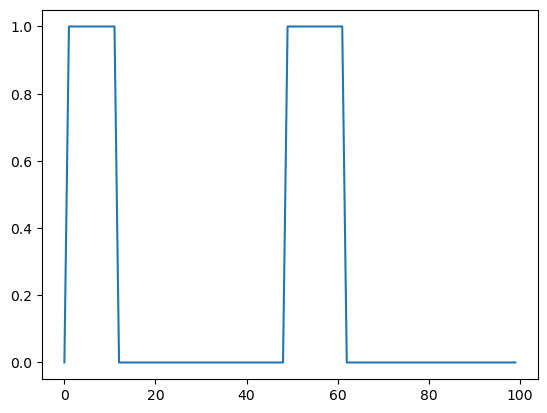

In [45]:
plt.plot(square_pulse)

In [46]:
def make_triangular_pulse():
    sample = np.zeros(100)
    for i in range(np.random.randint(1, 5)):  # making from 1 to 4 pulses
        start = np.random.randint(0, 80)
        width = np.random.randint(5, 20)
        if width % 2 == 1:
            width += 1  # if odd, make it even
        sample[start:start + width // 2] = np.linspace(0, 1, width // 2)
        sample[start + width // 2:start + width] = np.linspace(1, 0, width // 2)
    return sample

In [47]:
triangular_pulse = make_triangular_pulse()
triangular_pulse

array([0.        , 0.        , 0.        , 0.5       , 1.        ,
       1.        , 0.5       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.16666667,
       0.33333333, 0.5       , 0.66666667, 0.83333333, 1.        ,
       1.        , 0.83333333, 0.66666667, 0.5       , 0.33333333,
       0.16666667, 0.        , 0.        , 0.        , 0.        ,
       0.14285714, 0.28571429, 0.42857143, 0.        , 0.25      ,
       0.5       , 0.75      , 1.        , 1.        , 0.75      ,
       0.5       , 0.25      , 0.        , 0.14285714, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

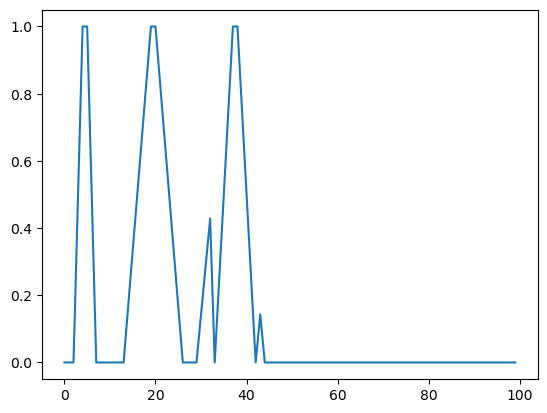

In [48]:
plt.plot(triangular_pulse)

In [49]:
n_each = 500
Xtrain = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttrain = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
n_each = 500
Xtest = np.array([make_square_pulse() for i in range(n_each)] +
                   [make_triangular_pulse() for i in range(n_each)])
Ttest = np.array(['square'] * n_each + ['triangular'] * n_each).reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 100), (1000, 1), (1000, 100), (1000, 1))

In [50]:
np.newaxis == None

True

In [51]:
Xtrain = Xtrain[:, None, :]
Xtrain.shape

(1000, 1, 100)

In [52]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, -1)
Xtest = Xtest.reshape(Xtest.shape[0], 1, -1)
Xtrain.shape, Xtest.shape

((1000, 1, 100), (1000, 1, 100))

adam: Epoch 10 Loss 0.581
adam: Epoch 20 Loss 0.401
adam: Epoch 30 Loss 0.140
adam: Epoch 40 Loss 0.042
adam: Epoch 50 Loss 0.008
adam: Epoch 60 Loss 0.002
adam: Epoch 70 Loss 0.001
adam: Epoch 80 Loss 0.001
adam: Epoch 90 Loss 0.000
adam: Epoch 100 Loss 0.000


Text(0.5, 1.0, 'Pulses')

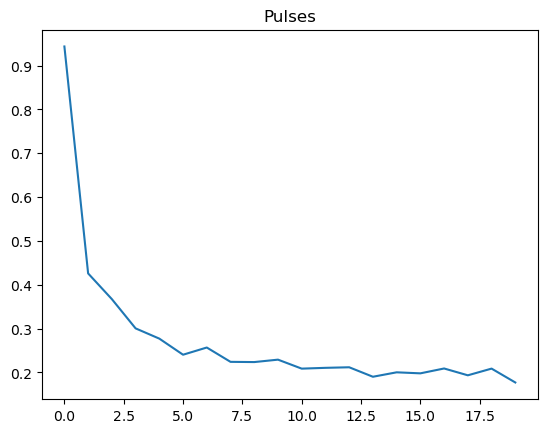

In [53]:
cnnet1 = CNN1D(100, [10, 5], [5, 5], 2, [10, 4], [1, 2], device=device)

n_epochs = 100
batch_size = 10
learning_rate = 0.001

cnnet1.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
cnnet1.error_trace = [e.detach().numpy() for e in cnnet.error_trace]

plt.plot(cnnet1.error_trace, label='Pytorch')
plt.title('Pulses')

In [54]:
Classes, _ = cnnet1.use(Xtest)
perc_correct = 100 * np.mean(Classes == Ttest)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
confusion_matrix(Classes, Ttest)

Test accuracy in percent correct: 98.40


,square,triangular
square,96.8,3.2
triangular,0.0,100.0


torch.Size([10, 10])

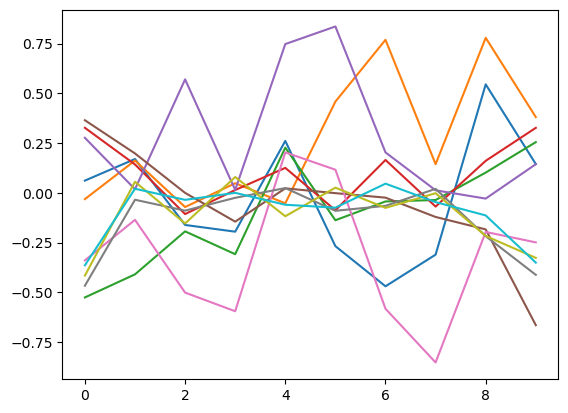

In [55]:
W = list(cnnet1.children())[0][0].weight.data.cpu()  # in case running on GPU
plt.plot(W[:, 0, :].T);
W[:, 0, :].T.shape

### Experiments on ECG Data

An [electrocardiogram](), or ECG, is a record in time of a voltage generated by the heart.  It can be used to diagnose abnormalities in the heart.

Public datasets containing ECG traces are available, such as the [Non-Invasive Fetal ECG Arrhythmia Database](https://physionet.org/content/nifeadb/1.0.0/) site. The data files there are in a standard waveform-database (WFDB) format.  As is often the case for most standard data formats you run in to, a python package exists for reading this data, called [wfdb](https://github.com/MIT-LCP/wfdb-python) that you can install using [conda](https://anaconda.org/conda-forge/wfdb).

This data set includes ECG from normal patients and from ones with arrythmias, with data file names like `ARR_01.dat` and `NR_01.dat`, respectively.  We have already downloaded these files, read them in using the `wfdb` package and collected them into segments of 2000 voltages.  The sample rate for this data is 1000 Hz, so 2000 voltages spans 2 seconds. Download this data set from [ecg.npy](https://www.cs.colostate.edu/~cs445/notebooks/ecg.npy) 

Now, our job for our `CNN1D` is to classify each 2000 sample segment into the classes `normal` or `arrythmia`.

After you have downloaded `ecg.npy`, you can load it and plot a few samples.

In [56]:
ecg = np.load('ecg.npy')
arr = ecg['arrythmia']
norm = ecg['normal']
arr.shape, norm.shape

((2429, 2000), (3634, 2000))

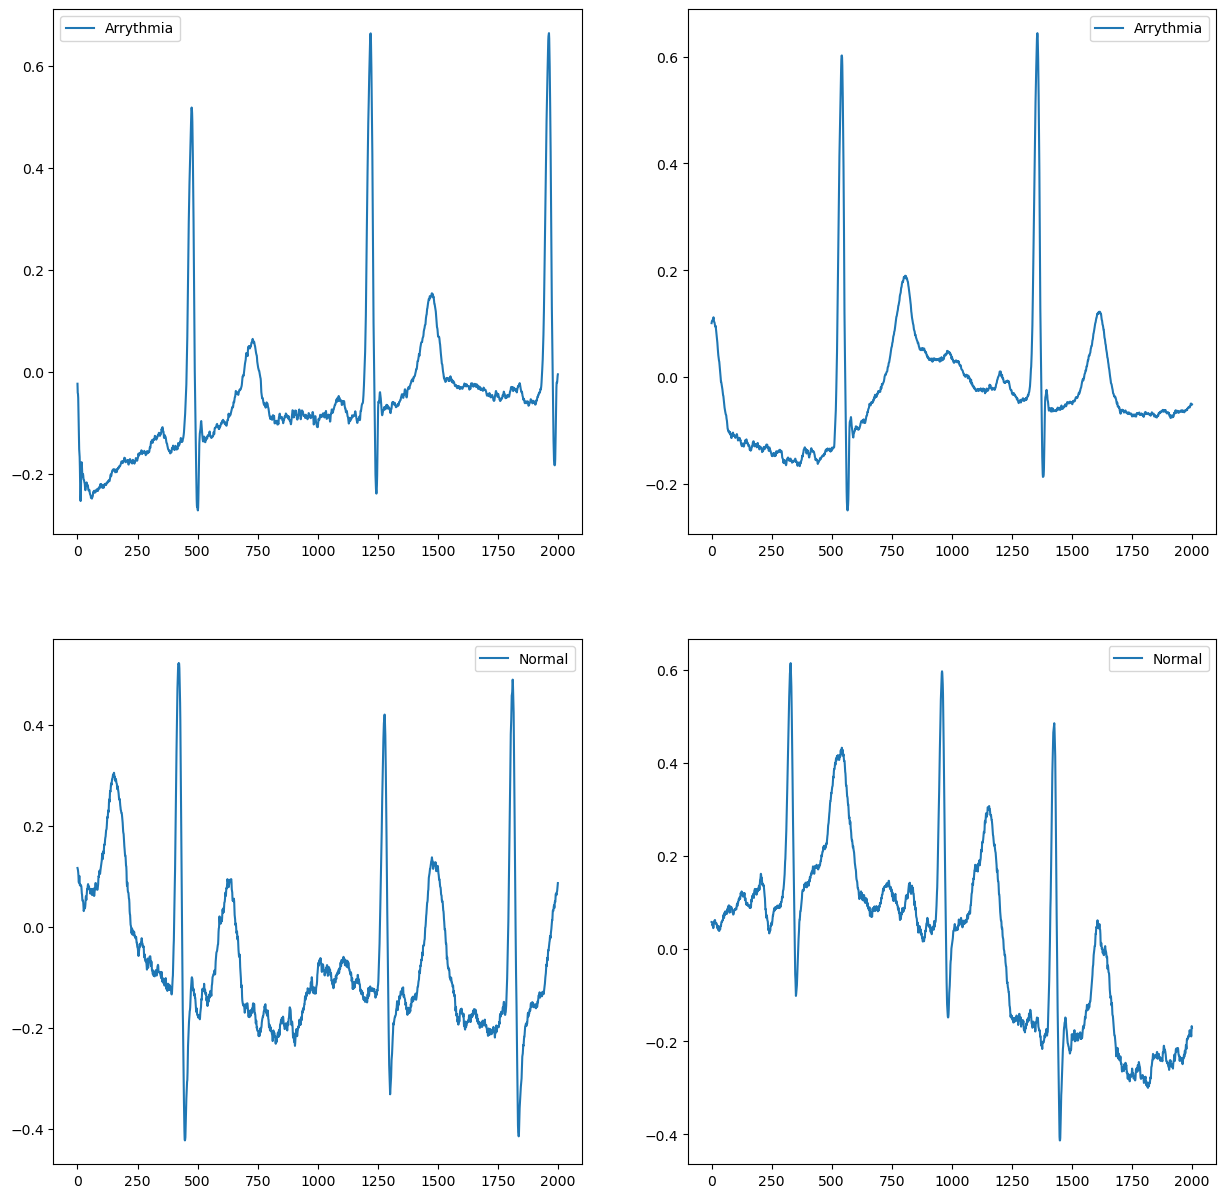

In [57]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(arr[0])
plt.legend(('Arrythmia',))
plt.subplot(2, 2, 2)
plt.plot(arr[100])
plt.legend(('Arrythmia',))

plt.subplot(2, 2, 3)
plt.plot(norm[0])
plt.legend(('Normal',))
plt.subplot(2, 2, 4)
plt.plot(norm[100])
plt.legend(('Normal',));

Now, let's stack the `arr` and `norm` samples together, create class labels for each sample, randomly rearrange them, and divide into train and test sets.

In [58]:
X = np.vstack((arr, norm))
X = X.reshape(X.shape[0], 1, -1)
T = np.hstack((['arr'] * arr.shape[0], ['nr'] * norm.shape[0])).reshape(-1, 1)
n_samples = X.shape[0]
rows = np.arange(n_samples)
np.random.shuffle(rows)
n_train = int(n_samples * 0.8)
Xtrain = X[rows[:n_train], ...]
Ttrain = T[rows[:n_train], ...]
Xtest = X[rows[n_train:], ...]
Ttest = T[rows[n_train:], ...]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((4850, 1, 2000), (4850, 1), (1213, 1, 2000), (1213, 1))

In [59]:
Ttrain

array([['nr'],
       ['nr'],
       ['arr'],
       ...,
       ['nr'],
       ['nr'],
       ['arr']], dtype='<U3')

Okay, ready to train.  Create a `CNN1D` network with a statements like this.

In [60]:
cnn1d = CNN1D(Xtrain.shape[-1], [5, 10], [10, 10], 2, [100, 20], [20, 5], device=device)

Now, experiment with at least ten different network structures, patch sizes and strides and compare them with the percent accuracy on test data.  Combine the results of each of your runs and display them in a `pandas.Dataframe` that includes the network structure and percent correct on train and test sets. Discuss your results, and describe the network structure and training parameters that produced the best test results.

In [63]:
network_structures = [
    {'conv_layers': [2], 'fc_layers': [1]},
    {'conv_layers': [2], 'fc_layers': [5]},
    {'conv_layers': [3], 'fc_layers': [1]},
    {'conv_layers': [3], 'fc_layers': [5]}
]

patch_sizes = [
    {'patch_size': [100], 'stride': [20]},
    {'patch_size': [20], 'stride': [5]},
    {'patch_size': [20], 'stride': [20]},
    {'patch_size': [100], 'stride': [5]}
]
results = []

for structure in network_structures:
    for patch_size in patch_sizes:
        cnn1d = CNN1D(Xtrain.shape[-1], structure['conv_layers'], structure['fc_layers'], 2, 
                      patch_size['patch_size'], patch_size['stride'], device=device)
        cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
        
        train_accuracy = np.mean(cnn1d.use(Xtrain)[0] == Ttrain) * 100
        test_accuracy = np.mean(cnn1d.use(Xtest)[0] == Ttest) * 100
        
        results.append({
            'Network Structure': structure['conv_layers'] + structure['fc_layers'],
            'Patch Size': patch_size['patch_size'],
            'Stride': patch_size['stride'],
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy
        })

results_df = pandas.DataFrame(results)

print(results_df)

adam: Epoch 10 Loss 0.630
adam: Epoch 20 Loss 0.623
adam: Epoch 30 Loss 0.616
adam: Epoch 40 Loss 0.611
adam: Epoch 50 Loss 0.608
adam: Epoch 60 Loss 0.605
adam: Epoch 70 Loss 0.603
adam: Epoch 80 Loss 0.601
adam: Epoch 90 Loss 0.599
adam: Epoch 100 Loss 0.598
adam: Epoch 10 Loss 0.662
adam: Epoch 20 Loss 0.647
adam: Epoch 30 Loss 0.639
adam: Epoch 40 Loss 0.633
adam: Epoch 50 Loss 0.628
adam: Epoch 60 Loss 0.623
adam: Epoch 70 Loss 0.618
adam: Epoch 80 Loss 0.615
adam: Epoch 90 Loss 0.612
adam: Epoch 100 Loss 0.610
adam: Epoch 10 Loss 0.621
adam: Epoch 20 Loss 0.591
adam: Epoch 30 Loss 0.584
adam: Epoch 40 Loss 0.581
adam: Epoch 50 Loss 0.579
adam: Epoch 60 Loss 0.578
adam: Epoch 70 Loss 0.577
adam: Epoch 80 Loss 0.576
adam: Epoch 90 Loss 0.575
adam: Epoch 100 Loss 0.574
adam: Epoch 10 Loss 0.624
adam: Epoch 20 Loss 0.613
adam: Epoch 30 Loss 0.607
adam: Epoch 40 Loss 0.606
adam: Epoch 50 Loss 0.600
adam: Epoch 60 Loss 0.598
adam: Epoch 70 Loss 0.595
adam: Epoch 80 Loss 0.589
adam: Epo

From my experiment, I found that a network structure of [2,5] with a patch size of 100 and a stride of 5 generated the best results. Additionally, I observed that deeper network architectures, especially ones with deeper convolutional layers, demonstrated better ECG classification accuracy. To test this, I created another experiment for deeper networks.

In [82]:
network_structures = [
    {'conv_layers': [10], 'fc_layers': [20]},
]

best_patch_size = [[100]]
best_stride = [[20]]

results = []

cnn1d = CNN1D(Xtrain.shape[-1], structure['conv_layers'], structure['fc_layers'], 2, 
              best_patch_size[0], best_stride[0], device=device)
cnn1d.train(Xtrain, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
    
train_accuracy = np.mean(cnn1d.use(Xtrain)[0] == Ttrain) * 100
test_accuracy = np.mean(cnn1d.use(Xtest)[0] == Ttest) * 100
    
results.append({
    'Network Structure': structure['conv_layers'] + structure['fc_layers'],
    'Patch Size': best_patch_size[i],
    'Stride': best_stride[i],
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
})

results_df = pandas.DataFrame(results)

print(results_df)

adam: Epoch 10 Loss 0.357
adam: Epoch 20 Loss 0.141
adam: Epoch 30 Loss 0.058
adam: Epoch 40 Loss 0.050
adam: Epoch 50 Loss 0.032
adam: Epoch 60 Loss 0.031
adam: Epoch 70 Loss 0.026
adam: Epoch 80 Loss 0.030
adam: Epoch 90 Loss 0.048
adam: Epoch 100 Loss 0.013
  Network Structure Patch Size Stride  Train Accuracy  Test Accuracy
0          [10, 20]      [100]   [20]       97.443299      71.805441


As expected, this deeper architecture outperformed shallower counterparts. The significantly higher train accuracy of 97.44% suggests that the model has successfully learned to represent the training data, while the test accuracy of 71.81% indicates its ability to generalize well to unseen data. This disparity between train and test accuracies is expected due to the deeper architecture's increased capacity, which may lead to overfitting.

## Grading and Check-In
Download [A5grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. Remember to test your code with additional tests of your own design. Your notebook must be named as Lastname-A5.ipynb.  

When ready, submit your notebook via the A5 link in our class Canvas web page.

In [83]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Roman-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    xs = np.arange(100)
    n_each = 500
    n_samples = n_each * 2
    X = np.array([np.sin(xs / 2) + np.random.normal(0, 1, size=100) for i in range(n_each)] +
                 [np.sin(xs / 3) + np.random.normal(0, 1, size=100) for i in range(n_each)])
    X = X[:, np.newaxis, :]
    T = np.array([2] * n_each + [3] * n_each).reshape(-1, 1)
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    X = X[rows, ...]
    T = T[rows, ...]
    n_train = int(n_samples * 0.8)
    Xtrain = X[:n_train, ...]
    Ttrain = T[:n_train, :]
    Xtest = X[n_train:, ...]
    Ttest = T[n_train:, :]

    cnn1d = CNN1D(100, [5, 5], [3], 2, [10, 5], [1, 2])
    cnn1d.train(Xtrain, Ttrain, 10, 20, 0.01, method='adam')

    perc_train = 100 * np.mean(cnn1d.u

## Extra Credit
Earn up to 3 extra credit points on this assignment by doing any or all of the following experiments. 

1. Compare your results on the MNIST data by using `relu` versus `tanh` activation functions. Show and discuss the results.
2. Compare your results on the MNIST data using `adam` versus `sgd`. Show and discuss the results.
3. Download another image data set, apply your `CNN2D` class to this data and discuss the results.